## Football Match Result Prediction

####  Abhishek Naithani - c0871411
#### Karishma Shirsath - c0871245
#### Tejaswi Kalla - c0852124
#### Venkata Sai Charan Yerapasetty - c0863224

1. [Libraries used](#libraries)
2. [Web Scraping Data](#scraping)
3. [Converting the data to csv and loading](#Convert)
4. [Pandas Profiling of raw data](#raw_profile)
5. [Data Pre-processing](#pre_process)
6. [Data Cleaning](#clean)
7. [Visualization](#visualization)
8. [Processing the data for prediction](#prediction)
9. [Applying ML Models](#model)

## 1. Libraries Used <a class="anchor" id="libraries"></a>


In [233]:
import pandas as pd
import requests
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

## 2. Web Scrapping data <a class="anchor" id="scraping"></a>

<div class="alert alert-block alert-info">
    
We have scrapped the data from the online site fbref, this site provides the data of all the matches in the laliga. For the scrapping we have considered data from multiple seasons(2022-2014) and the we have used the beautiful soup to get all the matches data and then concatinatced the shooting data of individual matches on the date column. Our final dataset contains all the details of every match played in laliga from 2022-2023 season to 2015-2014 season.
    
</div>

In [2]:
years = list(range(2022, 2014, -1))

In [3]:
all_matches = []

In [5]:
standings_url = "https://fbref.com/en/comps/12/2022-2023/2022-2023-La-Liga-Stats"

In [6]:
import time
for year in years:
    
    #getting individual team links
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    time.sleep(5)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    #to iterate and get the data from previous seasons
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")

        #getting the details of all matches from scores & fixtures table
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        time.sleep(5)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]

        #to get the shooting details of all the matches
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "PK", "PKatt"]], on="Date") # merging both tables data
        except ValueError:
            continue
        team_data = team_data[team_data["Comp"] == "La Liga"]
        
        team_data["Season"] = year
        team_data["Team"] = team_name
        all_matches.append(team_data)
        time.sleep(5)

In [7]:
match_df = pd.concat(all_matches)

In [8]:
match_df.columns = [c.lower() for c in match_df.columns]

In [9]:
match_df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0,0,Rayo Vallecano,...,Alejandro Hernández,Match Report,NaN,21.0,5.0,17.0,0.0,0.0,2022,Barcelona
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4,1,Real Sociedad,...,José Luis Munuera,Match Report,NaN,15.0,7.0,14.6,0.0,0.0,2022,Barcelona
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4,0,Valladolid,...,Ricardo de Burgos,Match Report,NaN,24.0,9.0,14.4,0.0,0.0,2022,Barcelona
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3,0,Sevilla,...,Antonio Matéu Lahoz,Match Report,NaN,18.0,5.0,16.0,0.0,0.0,2022,Barcelona
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4,0,Cádiz,...,Carlos del Cerro,Match Report,NaN,16.0,8.0,14.9,0.0,0.0,2022,Barcelona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,2016-04-21,21:00,La Liga,Matchweek 34,Thu,Away,L,1,5,Granada,...,Santiago Jaime,Match Report,NaN,15.0,5.0,NaN,0.0,0.0,2015,Levante
36,2016-04-24,12:00,La Liga,Matchweek 35,Sun,Home,D,2,2,Athletic Club,...,Ignacio Iglesias,Match Report,NaN,10.0,5.0,NaN,0.0,0.0,2015,Levante
37,2016-05-02,20:30,La Liga,Matchweek 36,Mon,Away,L,1,3,Málaga,...,Iñaki Bikandi,Match Report,NaN,11.0,5.0,NaN,0.0,0.0,2015,Levante
38,2016-05-08,17:00,La Liga,Matchweek 37,Sun,Home,W,2,1,Atlético Madrid,...,José González,Match Report,NaN,11.0,5.0,NaN,0.0,0.0,2015,Levante


 ## 3. Converting the data to csv and loading it <a class="anchor" id="Convert"></a>

In [10]:
match_df.to_csv("matches.csv")

In [234]:
df = pd.read_csv("matches.csv",index_col = 0)

In [235]:
df_copy = df

In [236]:
df.head(5)

,date,time,comp,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0.0,0.0,Rayo Vallecano,1.9,0.5,67.0,81104.0,Sergio Busquets,4-3-3,Alejandro Hernández,Match Report,NaN,21.0,5.0,17.0,0.0,0.0,2022,Barcelona
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4.0,1.0,Real Sociedad,2.1,0.8,58.0,36201.0,Marc-André ter Stegen,3-2-4-1,José Luis Munuera,Match Report,NaN,15.0,7.0,14.6,0.0,0.0,2022,Barcelona
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4.0,0.0,Valladolid,2.6,0.8,67.0,83972.0,Sergio Busquets,4-3-3,Ricardo de Burgos,Match Report,NaN,24.0,9.0,14.4,0.0,0.0,2022,Barcelona
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3.0,0.0,Sevilla,4.0,1.0,54.0,40233.0,Sergio Busquets,4-3-3,Antonio Matéu Lahoz,Match Report,NaN,18.0,5.0,16.0,0.0,0.0,2022,Barcelona
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4.0,0.0,Cádiz,3.4,0.4,70.0,19530.0,Sergio Busquets,4-3-3,Carlos del Cerro,Match Report,NaN,16.0,8.0,14.9,0.0,0.0,2022,Barcelona


## 4.Pandas profiling of raw data <a name='raw_profile'></a>

In [237]:
profile = pandas_profiling.ProfileReport(df)

profile.to_file("raw_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 5. Data Pre-processing <a name='pre_process'></a>

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6080 entries, 0 to 39
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          6080 non-null   object 
 1   time          6080 non-null   object 
 2   comp          6080 non-null   object 
 3   round         6080 non-null   object 
 4   day           6080 non-null   object 
 5   venue         6080 non-null   object 
 6   result        6080 non-null   object 
 7   gf            6080 non-null   float64
 8   ga            6080 non-null   float64
 9   opponent      6080 non-null   object 
 10  xg            4560 non-null   float64
 11  xga           4560 non-null   float64
 12  poss          6080 non-null   float64
 13  attendance    5104 non-null   float64
 14  captain       6080 non-null   object 
 15  formation     6080 non-null   object 
 16  referee       6080 non-null   object 
 17  match report  6080 non-null   object 
 18  notes         0 non-null      

In [239]:
df.describe()

,gf,ga,xg,xga,poss,attendance,notes,sh,sot,dist,pk,pkatt,season
count,6080.000000,6080.000000,4560.000000,4560.000000,6080.000000,5104.000000,0.0,6080.000000,6080.000000,4558.000000,6080.000000,6080.000000,6080.000000
mean,1.310691,1.310691,1.282215,1.282215,50.011349,27422.964342,NaN,11.656250,3.966447,18.296402,0.124178,0.163980,2018.500000
std,1.218254,1.218254,0.771650,0.771650,11.125865,19003.475525,NaN,4.747473,2.333981,3.363311,0.352941,0.408318,2.291476
min,0.000000,0.000000,0.000000,0.000000,18.000000,13.000000,NaN,0.000000,0.000000,4.800000,0.000000,0.000000,2015.000000
25%,0.000000,0.000000,0.700000,0.700000,42.000000,14131.250000,NaN,8.000000,2.000000,16.100000,0.000000,0.000000,2016.750000
50%,1.000000,1.000000,1.100000,1.100000,50.000000,19872.000000,NaN,11.000000,4.000000,18.200000,0.000000,0.000000,2018.500000
75%,2.000000,2.000000,1.700000,1.700000,58.000000,37792.000000,NaN,14.000000,5.000000,20.200000,0.000000,0.000000,2020.250000
max,10.000000,10.000000,5.600000,5.600000,82.000000,98485.000000,NaN,36.000000,17.000000,46.200000,3.000000,3.000000,2022.000000


In [240]:
df.shape

(6080, 26)

In [241]:
#duplicate values
df.duplicated().sum()

0

#### Checking for columns with missing values

In [242]:
percentage = (df.isnull().sum() / len(df)) * 100

missing_columns = percentage[percentage > 20]

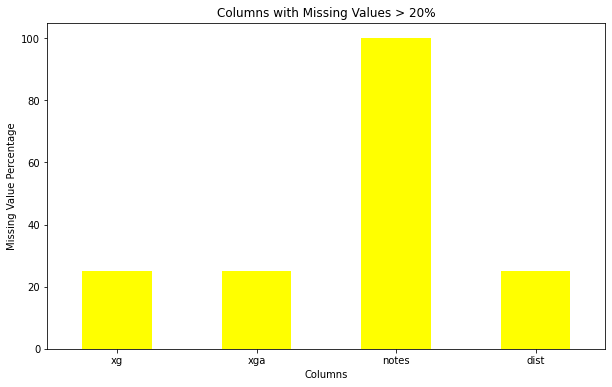

In [243]:
plt.figure(figsize=(10, 6))
missing_columns.plot(kind='bar', color='yellow')
plt.title('Columns with Missing Values > 20%')
plt.ylabel('Missing Value Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=0)
plt.show()

#### Above we have set a threshold of 20 percentage to verify the columns which have missing values greater than the threshold and we have got 'xg' ,'xga','notes','dist'. We are going to drop these columns as there are not useful for our analysis becuase

##### "xg" - this is expected goals to be scored by team, we don't need this column as this is not the real goals scored by a team and it has lot of missing values.


##### "xga" -  this is expected goals scored aganist a team , we are dropping this columns becasue of same reason as 'xga'

##### "notes" - notes column has almost all the values missing and it is irrelavant for our analysis


##### "dist" -  this is the  average distance travelled by each shot, this is less relavant to our analysis because a team can win with less average shot distance i.e with short passes and vice-versa and the missing values in this column are also high , even if we impute the records with mean , there is a high chance of introducing bias.




## 6.  Data Cleaning <a name='clean'></a>

#### Dropping columns with missing values

In [244]:
drop_columns = ['xg','xga','notes','dist']
df.drop(columns=drop_columns, inplace=True)

In [245]:
df.shape

(6080, 22)

### Dropping columns with less relevance to our analysis

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6080 entries, 0 to 39
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          6080 non-null   object 
 1   time          6080 non-null   object 
 2   comp          6080 non-null   object 
 3   round         6080 non-null   object 
 4   day           6080 non-null   object 
 5   venue         6080 non-null   object 
 6   result        6080 non-null   object 
 7   gf            6080 non-null   float64
 8   ga            6080 non-null   float64
 9   opponent      6080 non-null   object 
 10  poss          6080 non-null   float64
 11  attendance    5104 non-null   float64
 12  captain       6080 non-null   object 
 13  formation     6080 non-null   object 
 14  referee       6080 non-null   object 
 15  match report  6080 non-null   object 
 16  sh            6080 non-null   float64
 17  sot           6080 non-null   float64
 18  pk            6080 non-null   

#### We have identified few columns such as attendance, captain , match report , referee as less releavant columns becuase these columns does not affect the match result to more extent.

In [247]:
df = df.drop(['attendance',
              'captain','referee','match report'
             ],axis=1)

In [248]:
df.shape

(6080, 18)

## 7.Visualization <a name='visualization'></a>

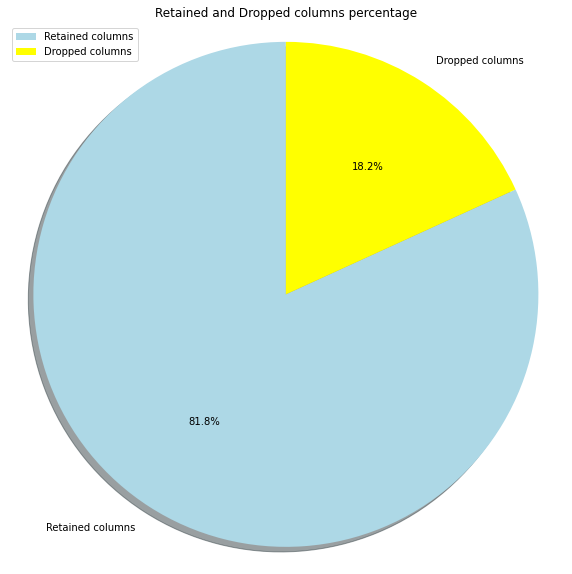

In [249]:
initial_columns = len(df_copy.columns)
final_columns = len(df.columns)
retained_percentage = (final_columns/initial_columns) * 100
dropped_percentage = 100 - retained_percentage


# Create pie chart
labels = ['Retained columns', 'Dropped columns']
sizes = [retained_percentage, dropped_percentage]
sizes = [max(0, val) for val in sizes]
colors = ['lightblue', 'yellow']
explode = (0.1,0)
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,shadow =True)
plt.axis('equal')
plt.legend(labels, loc="best")
plt.title('Retained and Dropped columns percentage')
plt.show()

#### From the above we can see 18 percent of the columns were dropped and 82 percent of the columns were retained.

In [250]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,formation,sh,sot,pk,pkatt,season,team
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0.0,0.0,Rayo Vallecano,67.0,4-3-3,21.0,5.0,0.0,0.0,2022,Barcelona
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4.0,1.0,Real Sociedad,58.0,3-2-4-1,15.0,7.0,0.0,0.0,2022,Barcelona
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4.0,0.0,Valladolid,67.0,4-3-3,24.0,9.0,0.0,0.0,2022,Barcelona
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3.0,0.0,Sevilla,54.0,4-3-3,18.0,5.0,0.0,0.0,2022,Barcelona
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4.0,0.0,Cádiz,70.0,4-3-3,16.0,8.0,0.0,0.0,2022,Barcelona


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6080 entries, 0 to 39
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6080 non-null   object 
 1   time       6080 non-null   object 
 2   comp       6080 non-null   object 
 3   round      6080 non-null   object 
 4   day        6080 non-null   object 
 5   venue      6080 non-null   object 
 6   result     6080 non-null   object 
 7   gf         6080 non-null   float64
 8   ga         6080 non-null   float64
 9   opponent   6080 non-null   object 
 10  poss       6080 non-null   float64
 11  formation  6080 non-null   object 
 12  sh         6080 non-null   float64
 13  sot        6080 non-null   float64
 14  pk         6080 non-null   float64
 15  pkatt      6080 non-null   float64
 16  season     6080 non-null   int64  
 17  team       6080 non-null   object 
dtypes: float64(7), int64(1), object(10)
memory usage: 1.0+ MB


#### Matches played by each team

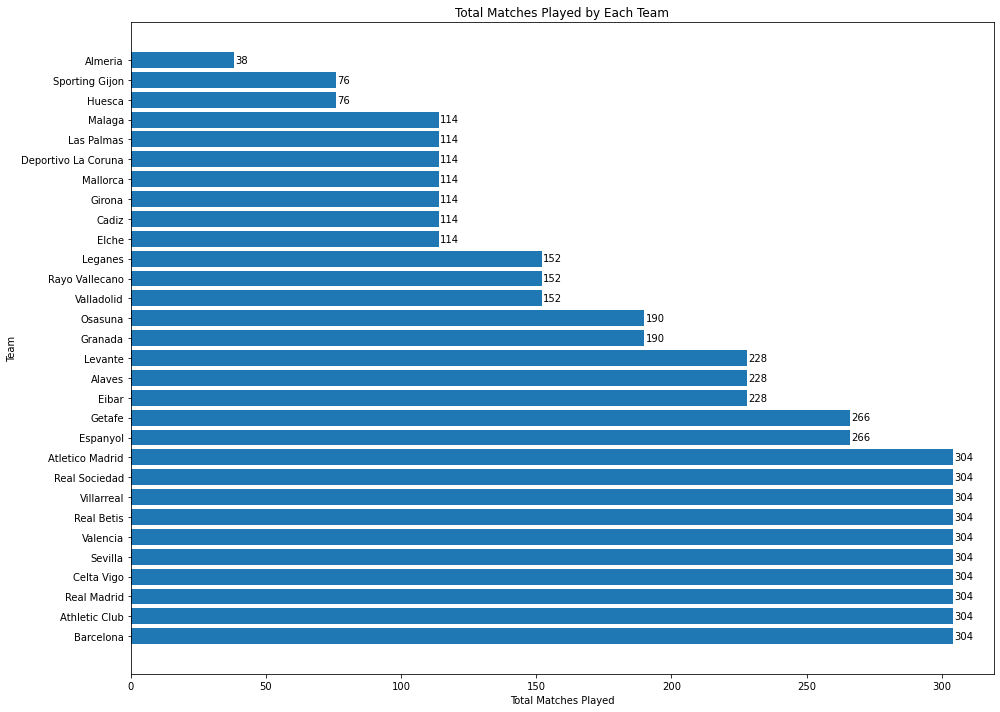

In [252]:
matches_played = df['team'].value_counts()

plt.figure(figsize=(14, 10))
bars = plt.barh(matches_played.index, matches_played.values)
plt.title('Total Matches Played by Each Team')
plt.xlabel('Total Matches Played')
plt.ylabel('Team')

for bar, matches in zip(bars, matches_played.values):
    plt.text(matches + 0.5, bar.get_y() + bar.get_height() / 2, str(matches), va='center')

plt.tight_layout()
plt.show()

#### From the above we can see the number of matches played by each team , the reason for few teams with less matches are there is a rule called relegation and the 3 teams which are below at the end of every season are relegated to the other division and the top 3 teams from the below division gets promoted to the above division 

In [253]:
goals_scored = df.groupby('team')['gf'].sum().reset_index()


fig = px.bar(goals_scored, x='team', y='gf', title='Total Goals Scored by Team', labels={'team': 'Team', 'gf': 'Total Goals Scored'})

# Adding numbers on top of the bars
for team, gf in zip(goals_scored['team'], goals_scored['gf']):
    fig.add_annotation(
        text=str(int(gf)),
        x=team,
        y=gf,
        xanchor='center',
        yanchor='bottom',
        showarrow=False
    )

fig.update_xaxes(tickangle=45)
fig.show()

#### From the above we can see the goals score by each team from 2022-2023 season to 2014- 2015 season . The top three teams in goals scoring are Barcelona, Real Madrid, Atletico Madrid

### Goals scored against each team

In [254]:

# Group by team and sum up the goals against
goals_against_team = df.groupby('team')['ga'].sum().reset_index()

# Create an interactive bar plot using Plotly
fig = px.bar(goals_against_team, x='team', y='ga', title='Total Goals Against each Team', labels={'team': 'Team', 'ga': 'Total Goals Against'})

# Add numbers on top of the bars
for team, ga in zip(goals_against_team['team'], goals_against_team['ga']):
    fig.add_annotation(
        text=str(int(ga)),
        x=team,
        y=ga,
        xanchor='center',
        yanchor='bottom',
        showarrow=False
    )
fig.update_traces(marker_color='brown')
fig.update_xaxes(tickangle=45)
fig.show()

#### Top 5 teams with most wins

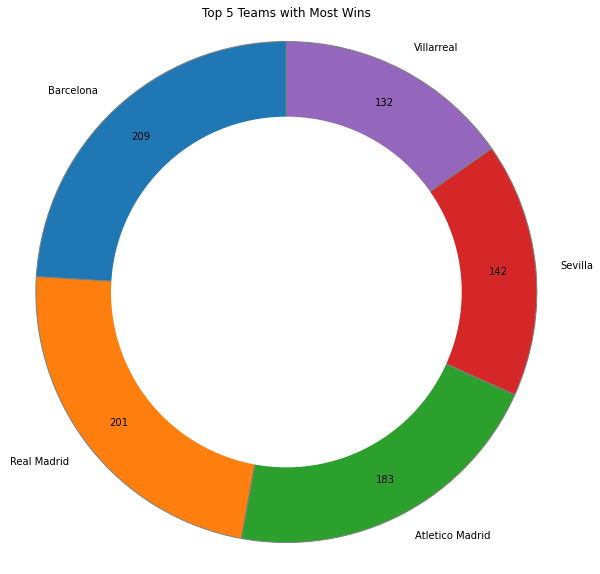

In [255]:
wins_by_team = df[df['result'] == 'W']['team'].value_counts()

top_teams = wins_by_team.head(5)

plt.figure(figsize=(10, 10))
plt.pie(top_teams, labels=top_teams.index, autopct=lambda p: f'{int(p * sum(top_teams) / 100):.0f}', startangle=90, pctdistance=0.85, wedgeprops={'edgecolor': 'grey'})
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Top 5 Teams with Most Wins')
plt.axis('equal')
plt.show()

## 8.Processing the data for prediction <a name='prediction'></a>

In [256]:
#converting to datetime
df["date"] = pd.to_datetime(df["date"])

#### Creating predictors 

In [257]:
#creating new column venue_code by using the existing venue column
df["venue_code"] = df["venue"].astype("category").cat.codes

In [258]:
#creating opponent code for each opponent
df["opp_code"] = df["opponent"].astype("category").cat.codes

In [259]:
df.head(5)

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,formation,sh,sot,pk,pkatt,season,team,venue_code,opp_code
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0.0,0.0,Rayo Vallecano,67.0,4-3-3,21.0,5.0,0.0,0.0,2022,Barcelona,1,22
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4.0,1.0,Real Sociedad,58.0,3-2-4-1,15.0,7.0,0.0,0.0,2022,Barcelona,0,24
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4.0,0.0,Valladolid,67.0,4-3-3,24.0,9.0,0.0,0.0,2022,Barcelona,1,28
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3.0,0.0,Sevilla,54.0,4-3-3,18.0,5.0,0.0,0.0,2022,Barcelona,0,25
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4.0,0.0,Cádiz,70.0,4-3-3,16.0,8.0,0.0,0.0,2022,Barcelona,0,7


#### setting up the target column to predict

In [260]:
#creating a target column based on the result
df["target"] = df["result"].map({"W": 1, "L": 0, "D": 2})

In [261]:
df['sot'] = df['sot'].astype(int)
df['gf'] = df['gf'].astype(int)

In [262]:
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,formation,sh,sot,pk,pkatt,season,team,venue_code,opp_code,target
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0,0.0,Rayo Vallecano,67.0,4-3-3,21.0,5,0.0,0.0,2022,Barcelona,1,22,2
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4,1.0,Real Sociedad,58.0,3-2-4-1,15.0,7,0.0,0.0,2022,Barcelona,0,24,1
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4,0.0,Valladolid,67.0,4-3-3,24.0,9,0.0,0.0,2022,Barcelona,1,28,1
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3,0.0,Sevilla,54.0,4-3-3,18.0,5,0.0,0.0,2022,Barcelona,0,25,1
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4,0.0,Cádiz,70.0,4-3-3,16.0,8,0.0,0.0,2022,Barcelona,0,7,1


#### In the above we can see target column is having values as 0 for lose, 1 for win , 2 for draw. Now based on this we are going to predict the results.

## pandas profiling

In [263]:
profile = pandas_profiling.ProfileReport(df)

profile.to_file("clean_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 9. Applying ML Models  <a name='model'></a>

### Three way classification of the result(win,lose,draw)

### RandomForest Classifier

In [264]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
#train and test data
train = df[df["date"] < '2022-01-01']
test = df[df["date"] > '2022-01-01']

#predictors
predictors = ["venue_code", "opp_code","sot"]

#fitting the model
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [265]:
pred = rf.predict(test[predictors])

In [266]:
accuracy = accuracy_score(test["target"], pred)
accuracy

0.5129757785467128

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.59      0.56       437
           1       0.58      0.65      0.61       437
           2       0.27      0.18      0.22       282

    accuracy                           0.51      1156
   macro avg       0.46      0.47      0.46      1156
weighted avg       0.49      0.51      0.50      1156



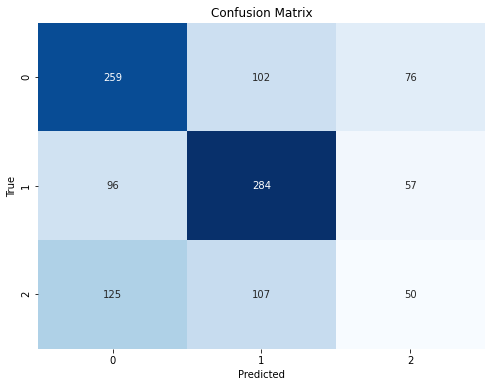

In [267]:
#classification report
report = classification_report(test["target"], pred)
print("Classification Report:\n", report)

#confusion matrix
matrix = confusion_matrix(test["target"], pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [268]:
#converting the predictions into dataframe
prediction_df = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": pred
})

prediction_df.to_csv("test_3way_predictions_rf.csv", index=False)

### Prediction on the train set

In [269]:
pred_train = rf.predict(train[predictors])

accuracy = accuracy_score(train["target"], pred_train)
accuracy

0.5885458976441917

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63      1812
           1       0.61      0.72      0.66      1812
           2       0.51      0.28      0.36      1300

    accuracy                           0.59      4924
   macro avg       0.57      0.56      0.55      4924
weighted avg       0.58      0.59      0.57      4924



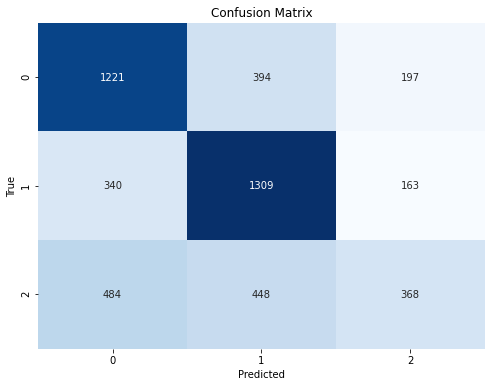

In [270]:
#classification report
report = classification_report(train["target"], pred_train)
print("Classification Report:\n", report)

#confusion matrix
matrix_train = confusion_matrix(train["target"], pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_train, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [271]:
#converting the predictions into dataframe
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": pred_train
})


prediction_df_train.to_csv("train_3way_predictions_rf.csv", index=False)

### xgboost

In [272]:
clf = xgb.XGBClassifier(n_estimators=10, random_state=10)

#fit on the training data
clf.fit(train[predictors], train["target"])

#predictions on the test data
xg_pred = clf.predict(test[predictors])

In [273]:
accuracy_xgb = accuracy_score(test["target"], xg_pred)
accuracy_xgb

0.5441176470588235

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.66      0.61       437
           1       0.56      0.72      0.63       437
           2       0.32      0.09      0.14       282

    accuracy                           0.54      1156
   macro avg       0.48      0.49      0.46      1156
weighted avg       0.50      0.54      0.50      1156



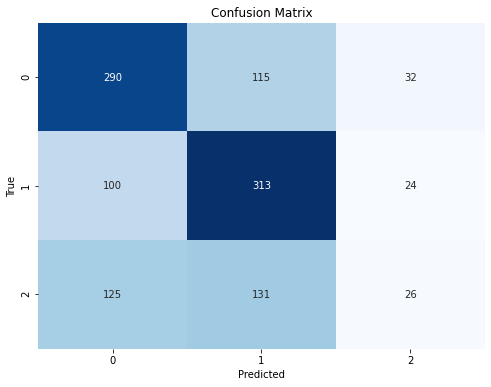

In [274]:
report_xgb = classification_report(test["target"], xg_pred)
print("Classification Report:\n", report_xgb)

matrix_xgb = confusion_matrix(test["target"], xg_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [275]:
prediction_df_xg = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": xg_pred
})

prediction_df_xg.to_csv("test_3way_predictions_xgb.csv", index=False)

### Prediction on train set

In [276]:
prediction_train_xgb = clf.predict(train[predictors])

accuracy = accuracy_score(train["target"], prediction_train_xgb)
accuracy

0.5664094232331438

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.67      0.62      1812
           1       0.58      0.75      0.65      1812
           2       0.48      0.15      0.23      1300

    accuracy                           0.57      4924
   macro avg       0.54      0.53      0.50      4924
weighted avg       0.55      0.57      0.53      4924



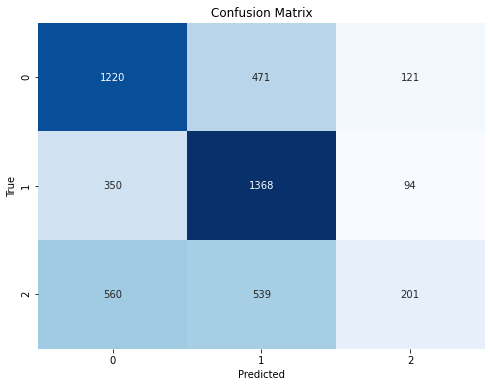

In [277]:
report_xgb_train = classification_report(train["target"], prediction_train_xgb)
print("Classification Report:\n", report_xgb_train)

matrix_xgb_train = confusion_matrix(train["target"], prediction_train_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb_train, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [278]:
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": prediction_train_xgb
})

prediction_df_train.to_csv("train_3way_predictions_xgb.csv", index=False)

### Logistic Regression

In [279]:
lr = LogisticRegression(random_state=42)
lr.fit(train[predictors], train["target"])

#predictions on the test data
lr_pred = lr.predict(test[predictors])

In [280]:
accuracy_lr = accuracy_score(test["target"], lr_pred)
accuracy_lr

0.5311418685121108

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.75      0.60       437
           1       0.57      0.65      0.61       437
           2       0.00      0.00      0.00       282

    accuracy                           0.53      1156
   macro avg       0.36      0.47      0.40      1156
weighted avg       0.41      0.53      0.46      1156



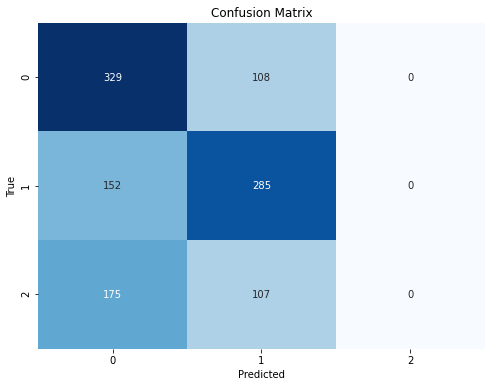

In [281]:
report_lr = classification_report(test["target"], lr_pred)
print("Classification Report:\n", report_lr)

matrix_lr = confusion_matrix(test["target"], lr_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_lr, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [282]:
prediction_df_lr = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": lr_pred
})

prediction_df_lr.to_csv("test_3way_predictions_lr.csv", index=False)

### Prediction on the train set

In [283]:
prediction_train_lr = lr.predict(train[predictors])

accuracy = accuracy_score(train["target"], prediction_train_lr)
accuracy

0.5073111291632819

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.71      0.57      1812
           1       0.55      0.67      0.60      1812
           2       0.00      0.00      0.00      1300

    accuracy                           0.51      4924
   macro avg       0.34      0.46      0.39      4924
weighted avg       0.38      0.51      0.43      4924



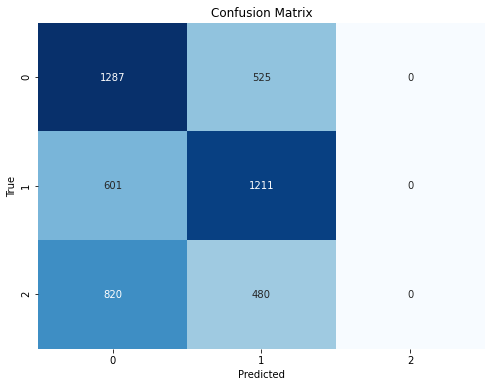

In [284]:
report_lr_train = classification_report(train["target"], prediction_train_lr)
print("Classification Report:\n", report_lr_train)

matrix_lr_train = confusion_matrix(train["target"], prediction_train_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_lr_train, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [285]:
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": prediction_train_lr
})

prediction_df_train.to_csv("train_3way_predictions_lr.csv", index=False)

#### From the above results we can see xgboost perfomed well when compared with the other two models. Logistic Regression performed very bad when it comes to predicting the draw result. Now we will try to predict the result in a two way and see if we can improve the performance of the models.

### Two way classification of the result(Win and Lose)

In [286]:
df["target"] = (df["result"] == "W").astype("int")

In [287]:
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,formation,sh,sot,pk,pkatt,season,team,venue_code,opp_code,target
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0,0.0,Rayo Vallecano,67.0,4-3-3,21.0,5,0.0,0.0,2022,Barcelona,1,22,0
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4,1.0,Real Sociedad,58.0,3-2-4-1,15.0,7,0.0,0.0,2022,Barcelona,0,24,1
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4,0.0,Valladolid,67.0,4-3-3,24.0,9,0.0,0.0,2022,Barcelona,1,28,1
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3,0.0,Sevilla,54.0,4-3-3,18.0,5,0.0,0.0,2022,Barcelona,0,25,1
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4,0.0,Cádiz,70.0,4-3-3,16.0,8,0.0,0.0,2022,Barcelona,0,7,1


### RandomForest Classifier

In [288]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
#train and test data
train = df[df["date"] < '2022-01-01']
test = df[df["date"] > '2022-01-01']

#predictors
predictors = ["venue_code", "opp_code","sot"]

#fitting the model
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [289]:
#prediction on test data
prediction = rf.predict(test[predictors])

In [290]:
#accuracy
accuracy = accuracy_score(test["target"], prediction)
accuracy

0.6955017301038062

In [291]:
#classification report
report = classification_report(test["target"], prediction)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77       719
           1       0.63      0.48      0.54       437

    accuracy                           0.70      1156
   macro avg       0.68      0.65      0.66      1156
weighted avg       0.69      0.70      0.69      1156



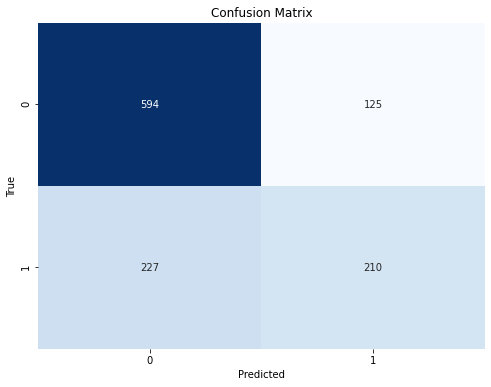

In [292]:
matrix = confusion_matrix(test["target"], prediction)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

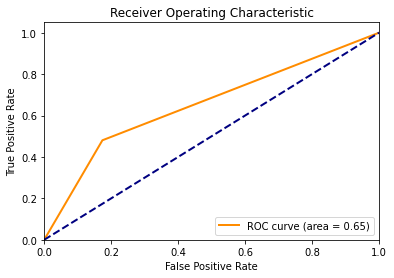

In [293]:
fpr, tpr, thresholds = roc_curve(test["target"], prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [294]:
#converting the predictions into dataframe
prediction_df = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": prediction
})


In [295]:
prediction_df.to_csv("test_predictions_rf.csv", index=False)

### Prediction on train set

In [296]:
prediction_train = rf.predict(train[predictors])

In [297]:
#accuracy
accuracy = accuracy_score(train["target"], prediction_train)
accuracy

0.7475629569455727

In [298]:
#classification report
report = classification_report(train["target"], prediction_train)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81      3112
           1       0.70      0.55      0.62      1812

    accuracy                           0.75      4924
   macro avg       0.73      0.71      0.71      4924
weighted avg       0.74      0.75      0.74      4924



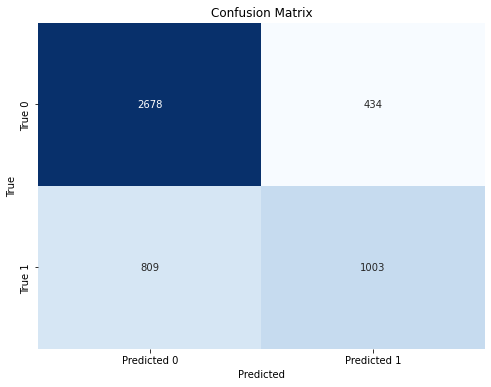

In [299]:
#confusion matrix
matrix_train = confusion_matrix(train["target"], prediction_train)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_train, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

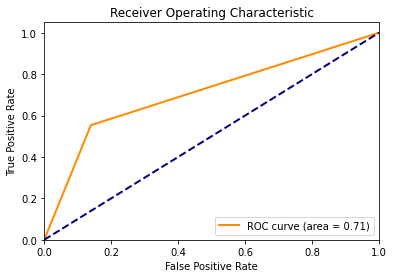

In [300]:
fpr, tpr, thresholds = roc_curve(train["target"], prediction_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [301]:
#converting the predictions into dataframe
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": prediction_train
})


In [302]:
prediction_df_train.to_csv("train_predictions_rf.csv", index=False)

### xgboost

In [303]:
clf = xgb.XGBClassifier(n_estimators=10, random_state=10)

#fit on the training data
clf.fit(train[predictors], train["target"])

#predictions on the test data
xg_pred = clf.predict(test[predictors])

In [304]:
accuracy_xgb = accuracy_score(test["target"], xg_pred)
accuracy_xgb

0.7093425605536332

In [305]:
report_xgb = classification_report(test["target"], xg_pred)
print("Classification Report:\n", report_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       719
           1       0.64      0.53      0.58       437

    accuracy                           0.71      1156
   macro avg       0.69      0.67      0.68      1156
weighted avg       0.70      0.71      0.70      1156



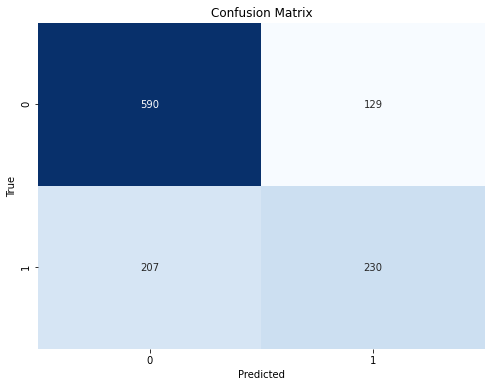

In [306]:
matrix_xgb = confusion_matrix(test["target"], xg_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

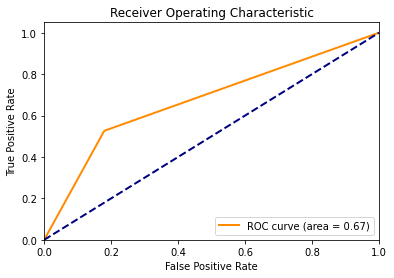

In [307]:
fpr, tpr, thresholds = roc_curve(test["target"], xg_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [308]:
prediction_df_xg = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": xg_pred
})

In [309]:
prediction_df_xg.to_csv("test_predictions_xgb.csv", index=False)

### Prediction on train set

In [310]:
prediction_train_xgb = clf.predict(train[predictors])

In [311]:
accuracy = accuracy_score(train["target"], prediction_train_xgb)
accuracy

0.7254264825345248

In [312]:
report_xgb_train = classification_report(train["target"], prediction_train_xgb)
print("Classification Report:\n", report_xgb_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79      3112
           1       0.65      0.54      0.59      1812

    accuracy                           0.73      4924
   macro avg       0.71      0.69      0.69      4924
weighted avg       0.72      0.73      0.72      4924



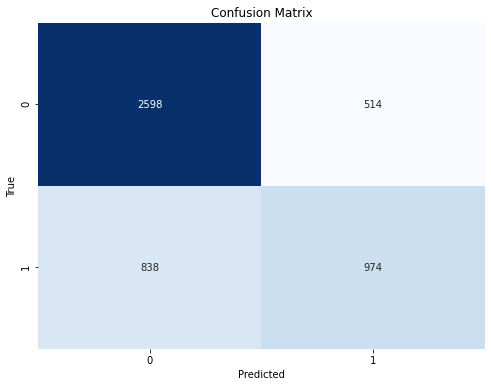

In [313]:
matrix_xgb_train = confusion_matrix(train["target"], prediction_train_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb_train, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

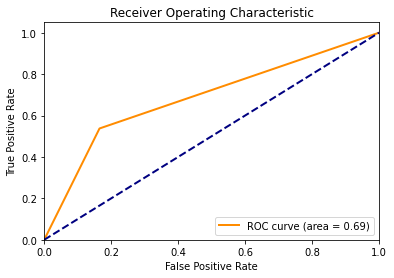

In [314]:
fpr, tpr, thresholds = roc_curve(train["target"], prediction_train_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [315]:
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": prediction_train_xgb
})

In [316]:
prediction_df_train.to_csv("train_predictions_xgb.csv", index=False)

### Logistic Regression

In [317]:
lr = LogisticRegression(random_state=42)
lr.fit(train[predictors], train["target"])

#predictions on the test data
lr_pred = lr.predict(test[predictors])

In [318]:
accuracy_lr = accuracy_score(test["target"], lr_pred)
accuracy_lr

0.6894463667820069

In [319]:
report_lr = classification_report(test["target"], lr_pred)
print("Classification Report:\n", report_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77       719
           1       0.64      0.42      0.50       437

    accuracy                           0.69      1156
   macro avg       0.67      0.64      0.64      1156
weighted avg       0.68      0.69      0.67      1156



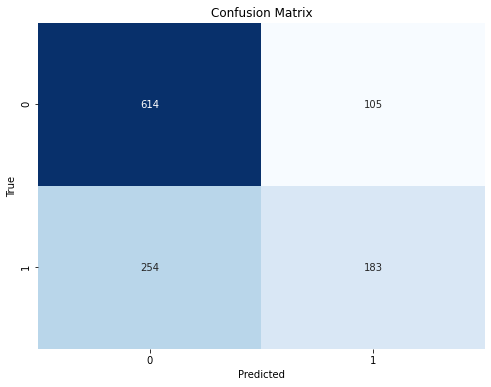

In [320]:
matrix_lr = confusion_matrix(test["target"], lr_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_lr, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

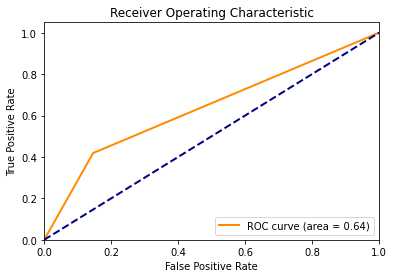

In [321]:
fpr, tpr, thresholds = roc_curve(test["target"], lr_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [322]:
prediction_df_lr = pd.DataFrame({
    "date": test["date"],
    "team": test["team"],
    "season": test["season"],
    "round": test["round"],
    "result": test["result"],
    "predicted_target": lr_pred
})

In [323]:
prediction_df_lr.to_csv("test_predictions_lr.csv", index=False)

### Prediction on train set

In [324]:
prediction_train_lr = lr.predict(train[predictors])

In [325]:
accuracy = accuracy_score(train["target"], prediction_train_lr)
accuracy

0.6917140536149472

In [326]:
report_lr_train = classification_report(train["target"], prediction_train_lr)
print("Classification Report:\n", report_lr_train)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.78      3112
           1       0.62      0.43      0.51      1812

    accuracy                           0.69      4924
   macro avg       0.67      0.64      0.64      4924
weighted avg       0.68      0.69      0.68      4924



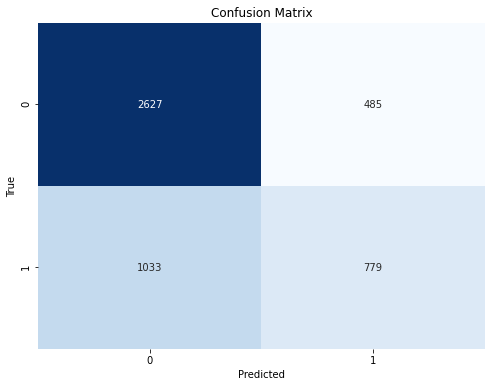

In [327]:
matrix_lr_train = confusion_matrix(train["target"], prediction_train_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_lr_train, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [328]:
prediction_df_train = pd.DataFrame({
    "date": train["date"],
    "team": train["team"],
    "season": train["season"],
    "round": train["round"],
    "result": train["result"],
    "predicted_target": prediction_train_lr
})

In [329]:
prediction_df_train.to_csv("train_predictions_lr.csv", index=False)

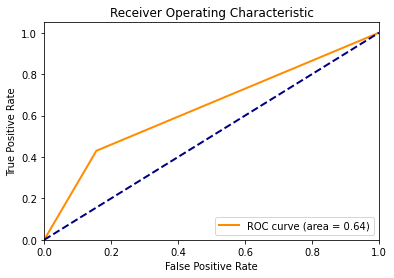

In [330]:
fpr, tpr, thresholds = roc_curve(train["target"], prediction_train_lr)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### From  the above results on the predcitions of test an train set we can observe all the models performed in almost similar way in terms of all the accuracy measures . xg boost performed slighlty better when compared to random forest and logistic regression


<div class="alert alert-block alert-info">

In conclusion when we predicted in a three way the results were pretty bad this might be because of the less data on the draw results becuase in 
most of the matches either of the team wins, so in a two way prediction we considered loss and draw as loss and it improved the performance of the model.

</div>